In [84]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

NUM_FULLY_COVERED = 1451
NUM_NOT_COVERED = 3664
NUM_NOT_FACE = 1114
NUM_PARTIALLY_COVERED = 392
NUM_OF_EACH_LABEL = [NUM_FULLY_COVERED, NUM_NOT_COVERED, NUM_NOT_FACE, NUM_PARTIALLY_COVERED]

LABELS = ["Fully covered", "Not covered", "Not face", "Partially covered"]

# Checks if feature data has been created locally
if not os.path.exists("mask_data.csv"):
    import featurize
    
data = np.array(pd.read_csv('mask_data.csv', sep=',',header=None))
X, Y = np.split(data, [-1], axis=1)
Y = Y.flatten()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# PCA dimensionality reduction

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X.shape[1])

def binary_search_helper(left, right, X, Y, target):
    if left > right:
        raise ValueError("Binary search helper called with left > right")
    
    mid = (left + right) // 2
    pca.set_params(**{'n_components':mid})
    pca.fit(X, Y) if Y is not None else pca.fit(X)
    variance = sum(pca.explained_variance_ratio_)    
    print("Explained variance ratio when mapping to {} dimensions is {}".format(
        mid, variance
    ))
        
    # Base case
    if left == right:
        # Use None to denote that we tried exploring left path but it was too low
        return left if variance >= target else None 
    
    # Recursive case
    if variance == target:
        return mid
    elif variance >= target:
        left_result = binary_search_helper(left, mid - 1, X, Y, target)
        return left_result if left_result is not None else mid
    else:
        return binary_search_helper(mid + 1, right, X, Y, target)
        
    

def required_dimensions(target, X, Y=None) -> int:
    """
    Returns the minimum number of dimensions we can reduce the dataset given by X and Y to 
    while keeping an explained variance of no less than target.
    """
#     variance = 0
#     n_dims = 0
#     pca = PCA(n_components=n_dims)
#     while variance < target and n_dims < X.shape[0]:
#         n_dims += 1
#         pca.set_params(**{'n_components':n_dims})
#         pca.fit(X, Y) if Y is not None else pca.fit(X)
#         variance = sum(pca.explained_variance_ratio_)
#         print("Explained variance ratio when mapping to {} dimensions is {}".format(
#             n_dims, variance
#         ))
    return binary_search_helper(0, X.shape[1] - 1, X, Y, target)
        

# pca = PCA(n_components=100)
# pca.fit(X, Y)

# print(pca.explained_variance_ratio_)

print(required_dimensions(0.99, X, Y))

Explained variance ratio when mapping to 2047 dimensions is 0.9991001644906737
Explained variance ratio when mapping to 1023 dimensions is 0.9942009740012087
Explained variance ratio when mapping to 511 dimensions is 0.9830774581451497
Explained variance ratio when mapping to 767 dimensions is 0.9904079344470352
Explained variance ratio when mapping to 639 dimensions is 0.9874218586628842
Explained variance ratio when mapping to 703 dimensions is 0.9890433996048851
Explained variance ratio when mapping to 735 dimensions is 0.9897573776839793
Explained variance ratio when mapping to 751 dimensions is 0.9900881405388836
Explained variance ratio when mapping to 743 dimensions is 0.989923780037017
Explained variance ratio when mapping to 747 dimensions is 0.9900096282304909
Explained variance ratio when mapping to 745 dimensions is 0.9899694650765102
Explained variance ratio when mapping to 746 dimensions is 0.9899862042878572
747


Thus, we can try mapping the data to $\mathbb{R}^{747}$ to reduce computational cost later

In [34]:
pca = PCA(n_components=747)
pca.fit(X, Y)
X = pca.transform(X)
pca_output = np.hstack((X, Y.reshape(-1, 1)))

In [4]:
df = pd.DataFrame(pca_output)
with open("pca_data.csv", 'w') as f:
    df.to_csv(f, header=False, index=False)

# Data visualization (Polynomial Kernel PCA)

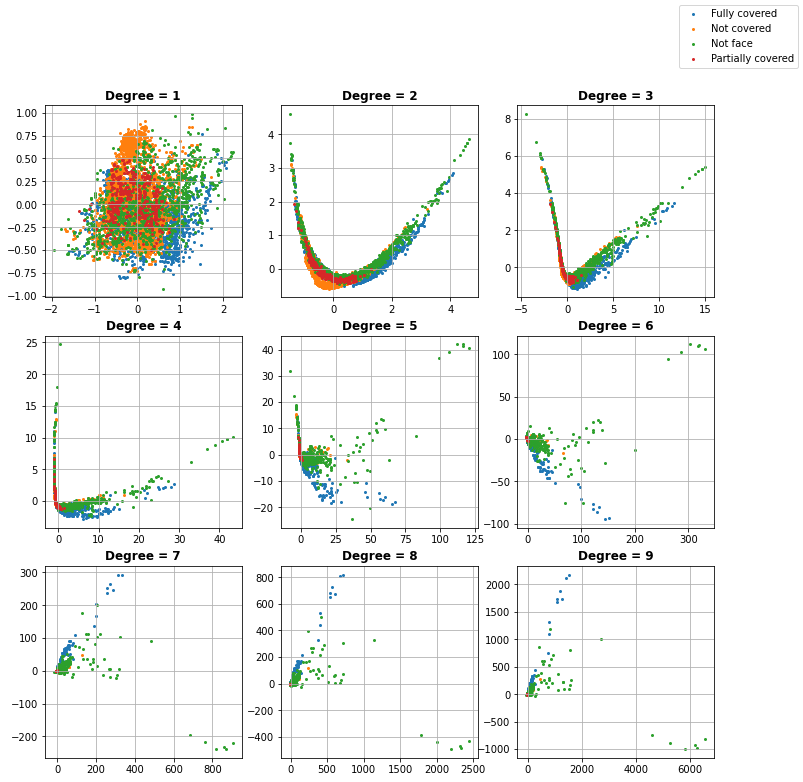

In [86]:
from sklearn.decomposition import KernelPCA
%matplotlib inline

def poly_kernel_pca_display(degrees):
    fig = plt.figure(num='Polynomial kernel PCA visualization', figsize=(12,12))
    fig.set_facecolor("white")
    plt.rcParams['figure.figsize'] = [100, 100]
    plt.rcParams['figure.dpi'] = 900
    for index, degree in enumerate(degrees):
        transformer = KernelPCA(n_components=2, kernel='poly', n_jobs=-1, degree=degree)
        X_kernelpca = transformer.fit_transform(X)
        plt.subplot(3, 3, index + 1)
        end_index = 0
        for label, population_size in enumerate(NUM_OF_EACH_LABEL):
            start_index = end_index
            end_index += population_size
            x_plt, y_plt = np.split(X_kernelpca[start_index:end_index,:], [1],axis=1)
            plt.scatter(x_plt, y_plt, s=4, label=LABELS[label])
            plt.title("Degree = {}".format(degree), fontdict={
                "fontsize": 12,
                "fontweight": "bold"
            })
        plt.grid()
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    
        
poly_kernel_pca_display(range(1, 10))

# Data Visualization (RBF Kernel PCA)

In [ ]:
plt.clf()
%matplotlib inline
def rbf_kernel_pca_display(gammas):
    fig = plt.figure(num='Gaussian kernel PCA visualization', figsize=(12,12))
    fig.set_facecolor("white")
    plt.rcParams['figure.figsize'] = [100, 100]
    plt.rcParams['figure.dpi'] = 900
    for index, gamma in enumerate(gammas):
        transformer = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1, gamma=gamma)
        X_kernelpca = transformer.fit_transform(X)
        plt.subplot(3, 3, index + 1)
        end_index = 0
        for label, population_size in enumerate(NUM_OF_EACH_LABEL):
            start_index = end_index
            end_index += population_size
            x_plt, y_plt = np.split(X_kernelpca[start_index:end_index,:], [1],axis=1)
            plt.scatter(x_plt, y_plt, s=4, label=LABELS[label])
            plt.title("Gamma = {}".format(gamma), fontdict={
                "fontsize": 12,
                "fontweight": "bold"
            })
        plt.grid()
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    
        
rbf_kernel_pca_display([10 ** p for p in range(-5, 5)])

# Visualizing data with t-SNE

In [ ]:
from sklearn.manifold import TSNE

%matplotlib notebook
plt.clf()
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100

X_embedded = TSNE(
    n_components=2, 
    learning_rate='auto', 
    init='random', 
    perplexity=5
).fit_transform(X)


fig, ax = plt.subplots()
end_index = 0
for label, population_size in enumerate(NUM_OF_EACH_LABEL):
    start_index = end_index
    end_index += population_size
    ax.scatter(X_embedded[start_index : end_index, 0], X_embedded[start_index : end_index, 1], label=LABELS[label])

ax.legend()

# SVM Classification using various kernels

In [ ]:
from sklearn import svm

def svm_experiment(kernel : str, C : int, k : int, degree=3):
    """
    Sample code for SVM svc from https://scikit-learn.org/stable/modules/cross_validation.html
    
    Helper function to run k-fold cross validation on a SVM with a specified kernel.
    Returns the trained classifier.
    """
    clf = svm.SVC(kernel=kernel, C=C, random_state=0, degree=degree)
    scores = cross_val_score(clf, X, Y, cv=k)
    print("%0.2f accuracy with a standard deviation of %0.2f for {} kernel" % (
        scores.mean(), scores.std(), kernel)
     )
    return clf

In [ ]:
import threading as th

kernels = ["rbf", "poly","sigmoid"]
for kernel in kernels:
    th.Thread(target=svm_experiment, name=kernel, args=(kernel, 1, 5)).start()


In [ ]:
linear_svm_model = svm_experiment("linear", 1, 5)

In [ ]:
gaussian_svm_model = svm_experiment("rbf", 1, 5)

In [ ]:
cubic_svm_model = svm_experiment("poly", 1, 5, 3)

# XGBoost parameter fitting

In [ ]:
import xgboost as xgb

param = {
    'max_depth':7, 
#     'min_child_weight':1, 
#     'gamma':1,
#     'eta':2, 
    'num_class':4,
#     'subsample':0.8,
#     'colsample_bytree':0.8,
}

def xgb_experiment(rounds : int, k : int, param : dict):
    """ 
    Sample code for xgboost from:
    https://xgboost.readthedocs.io/en/latest/python/examples/cross_validation.html
    """
    dtrain = xgb.DMatrix(X, label=Y)

    return xgb.cv(param, dtrain, rounds, nfold=k,
           metrics={'merror'}, early_stopping_rounds=10, seed=0,
           callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

xgb_experiment(10, 5, param)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
"""
Example tuning from 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
"""

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':[10 ** p for p in range(-3, 0)]
}

gsearch1 = GridSearchCV(
    estimator=XGBClassifier(
        max_depth=5, 
        min_child_weight=1, 
        gamma=0,
        eta=2, 
        num_class=4,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="merror"
    ),
    param_grid=param_test1,
)

In [ ]:
gsearch1.fit(X, Y)

gsearch1.best_params_, gsearch1.best_score_